In [1]:
pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-y_2742zd
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-y_2742zd
  Resolved https://github.com/tensorflow/examples.git to commit fff4bcda7201645a1efaea4534403daf5fc03d42
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1703207612.1461250479831370929614362828255168868146460245314-py3-none-any.whl size=301582 sha256=2c8a2bf6653f8630ebb8d73ba044a612d36b2a5a04d49d3d109ccc7a1c1caa57
  Stored in directory: /tmp/pip-ephem-wheel-cache-jfv6j9z9/wheels/72/5f/d0/7fe769eaa229bf20101d11a357eb23c83c481bee2d7f710599
Successfully built tensorflow-examples


In [2]:
import tensorflow as tf

import tensorflow_datasets as tfds

In [3]:
from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [4]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete5BMI8K/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete5BMI8K/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [6]:
#Маски являются метками классов для каждого пикселя. Каждому пикселю присваивается одна
#из трех категорий:
#Класс 1: пиксель, принадлежащий питомцу.
#Класс 2: пиксель, граничащий с питомцем.
#Класс 3: ничего из вышеперечисленного/окружающий пиксель.
#Значения цвета изображения нормализованы к диапазону [0,1] . Наконец, как упоминалось выше, пиксели в маске
#сегментации помечены {1, 2, 3}. Для удобства вычитаем 1 из маски сегментации, чтобы получить
#следующие метки: {0, 1, 2}.

def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [7]:
#
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [8]:
#Набор данных уже содержит необходимые обучающие и тестовые сплиты, поэтому
# используем те же сплиты.
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [9]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [10]:
#Следующий класс выполняет простое увеличение, случайным образом переворачивая изображение.
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [11]:
#Создаём входной конвейер, применяя расширение после пакетирования входных данных.
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

In [12]:
#Визуализируем пример изображения и соответствующую ему маску из набора данных.
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

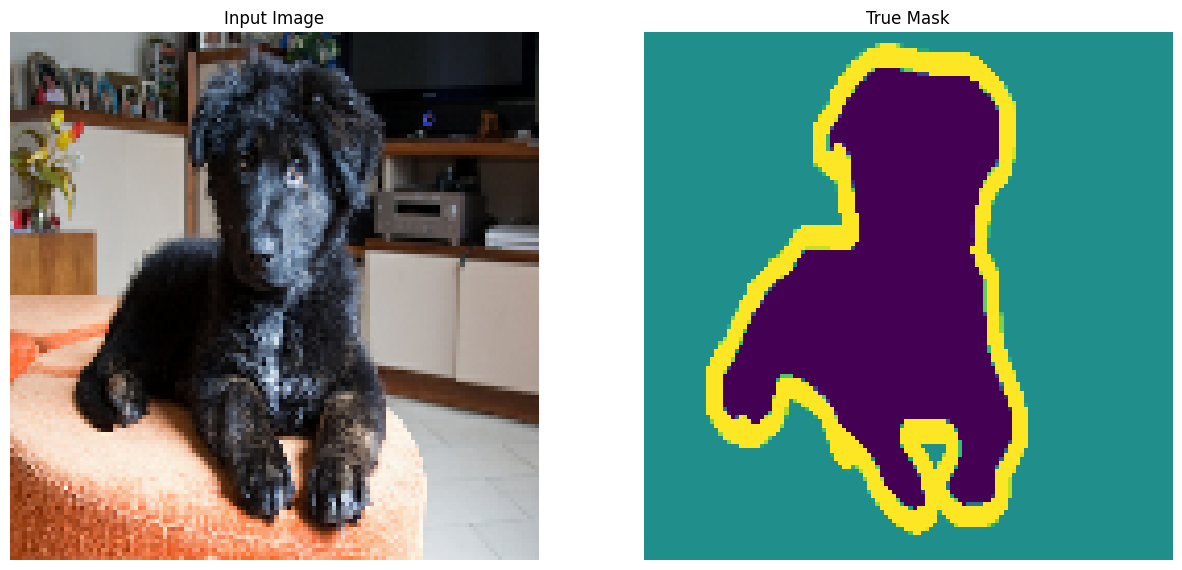

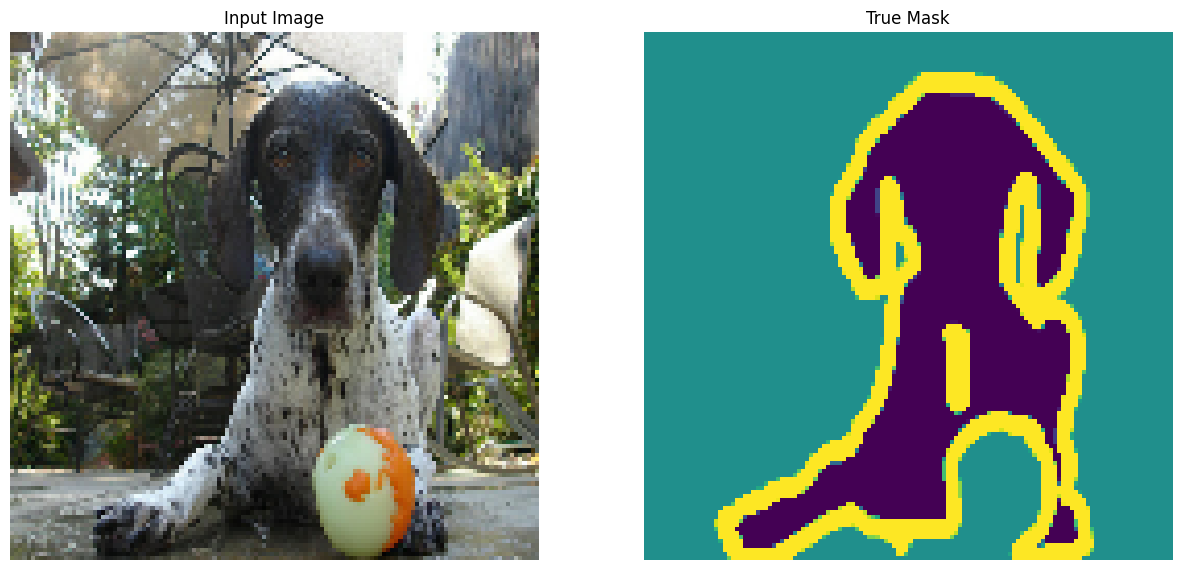

In [13]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

In [14]:

#Модель- модифицированная U-Net.
#Используем предварительно обученную модель — MobileNetV2 — в качестве кодировщика
# Кодер состоит из конкретных выходных данных промежуточных слоев модели.
# Кодер не будет обучаться в процессе обучения.

base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [15]:
#Декодер/апсемплер — это просто серия блоков повышающей дискретизации,
#реализованных в примерах TensorFlow.
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [16]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)
  #Количество фильтров на последнем слое равно количеству
  #output_channels . Это будет один выходной канал на класс.

In [18]:
#Компиляция и обучение модели.

#Используем функцию потерь tf.keras.losses.CategoricalCrossentropy с аргументом from_logits , установленным в True ,
#поскольку метки представляют собой скалярные целые числа, а не векторы оценок для каждого пикселя каждого класса.

OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])



In [ ]:
#Архитектура модели
tf.keras.utils.plot_model(model, show_shapes=True)

In [23]:
#Предсказание перед обучением
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [24]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 0s 98ms/step


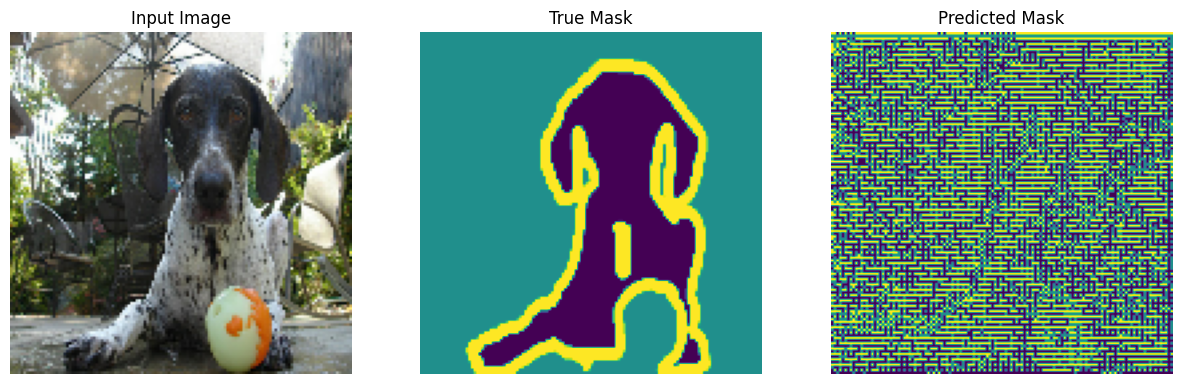

In [25]:
show_predictions()

1/1 [==============================] - 0s 54ms/step


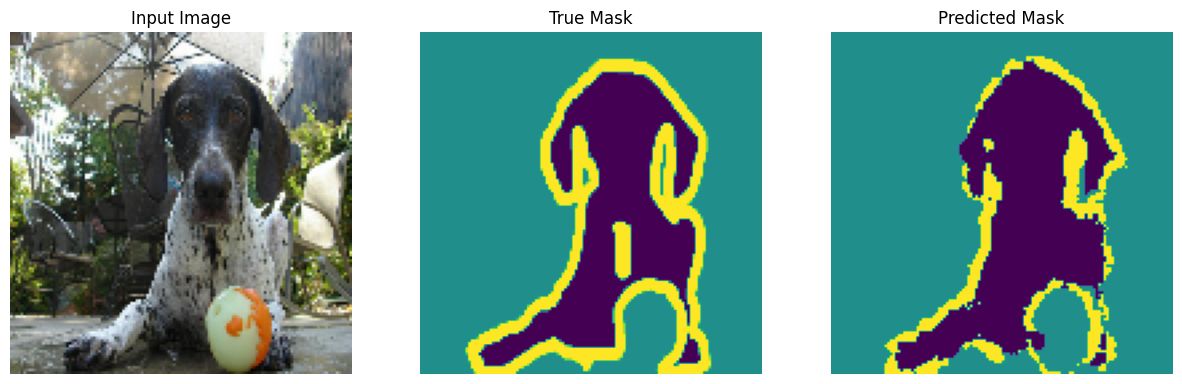


Sample Prediction after epoch 20

57/57 [==============================] - 328s 6s/step - loss: 0.1827 - accuracy: 0.9189 - val_loss: 0.2799 - val_accuracy: 0.8949


In [27]:
#Обратный вызов, определенный ниже, используется для наблюдения за тем, как модель улучшается
#во время ее обучения.
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))


EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

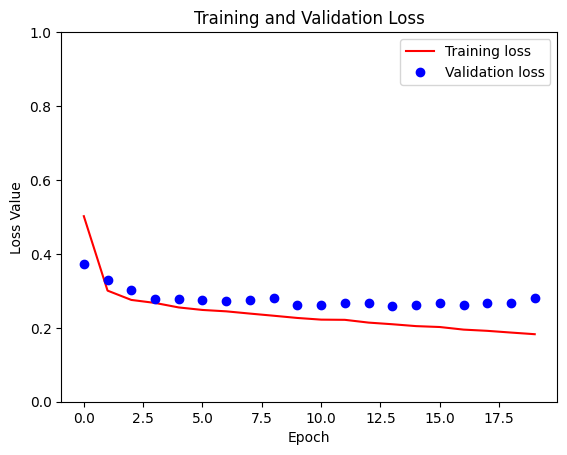

In [28]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

2/2 [==============================] - 3s 1s/step


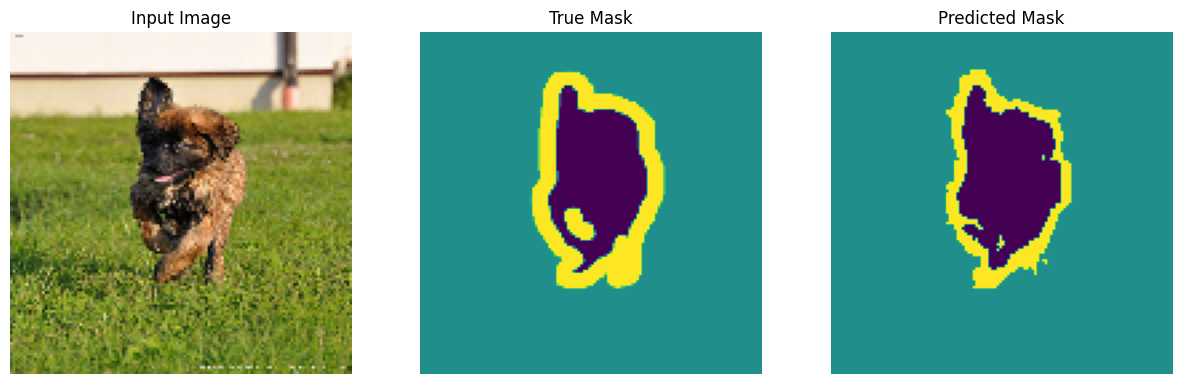

2/2 [==============================] - 2s 988ms/step


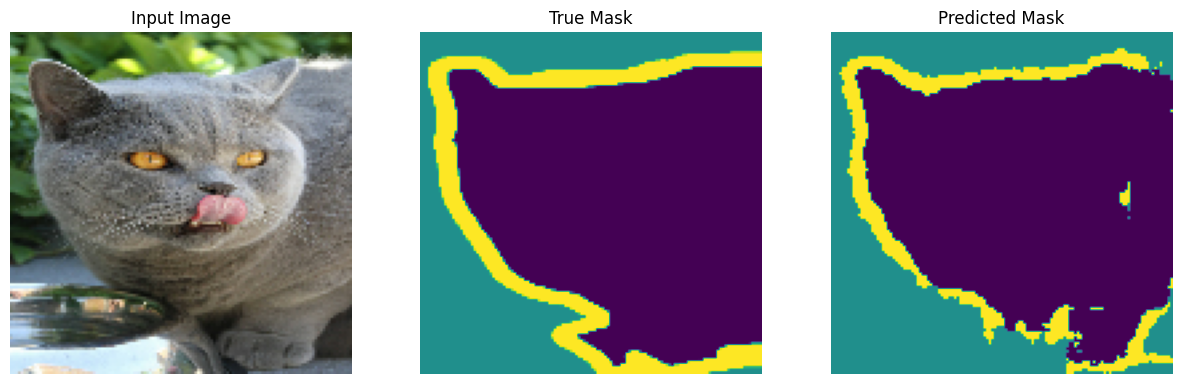

In [30]:
#Делаем предсказания

show_predictions(test_batches, 2)

Точность увеличилась ввиду увеличения количества epochs до 20.